<a href="https://colab.research.google.com/github/r-karra/GSoC-2026-Research/blob/main/quantum_attention_demo_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation & Setup

In [1]:
# Install the necessary research stack
!pip install -q pennylane jax jaxlib flax optax matplotlib


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


# Import Libraries & Configure JAX

In [2]:
import jax
import jax.numpy as jnp
import pennylane as qml
import matplotlib.pyplot as plt
from flax import nnx
import optax

# Setup JAX for 64-bit precision (common in physics research)
jax.config.update("jax_enable_x64", True)

print(f"JAX Device: {jax.devices()}")

JAX Device: [CpuDevice(id=0)]


# The Data Sequence (KJV Verses to Vectors)



In [3]:
# Sample Verses from your KJV Dataset
verses = [
    "In the beginning God created the heaven and the earth.",
    "And the earth was without form, and void;",
    "And darkness was upon the face of the deep.",
    "And the Spirit of God moved upon the face of the waters.",
    "And God said, Let there be light: and there was light."
]

# Simple "Semantic Embedding" Simulation (e.g., Word2Vec style)
# Each verse becomes a 4-dimensional vector (normalized for Quantum Gates)
# In Physics, these would be [px, py, pz, E] of particles.
def get_dummy_embeddings(num_sequences, dim=4):
    key = jax.random.PRNGKey(42)
    raw_data = jax.random.normal(key, (num_sequences, dim))
    # Normalize to [0, pi] for Angle Embedding
    normalized = jnp.pi * (raw_data - raw_data.min()) / (raw_data.max() - raw_data.min())
    return normalized

sequence_data = get_dummy_embeddings(len(verses))
print(f"Sequence Shape: {sequence_data.shape} (5 verses, 4 features each)")

Sequence Shape: (5, 4) (5 verses, 4 features each)


# The Quantum Attention Circuit

In [4]:
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="jax")
def quantum_attention_layer(inputs, weights):
    # Data Encoding
    qml.AngleEmbedding(inputs, wires=range(n_qubits))

    # Trainable Variational Layers (Entanglement)
    # This acts as the 'Attention Weight' learner
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))

    # Measure expectation values
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Vectorize the circuit to handle the whole sequence at once
vnode = jax.vmap(quantum_attention_layer, in_axes=(0, None))

# Training Loop (Dummy Loss)

In [5]:
# Initialization
n_layers = 2
key = jax.random.PRNGKey(0)
weights = jax.random.normal(key, (n_layers, n_qubits, 3))
optimizer = optax.adam(learning_rate=0.1)
opt_state = optimizer.init(weights)

# Targeted attention: we want the 5th verse to produce the highest 'signal'
target_output = jnp.array([1.0, 1.0, 1.0, 1.0]) # High energy target

def loss_fn(w, x):
    predictions_per_qubit_and_verse = vnode(x, w)
    # predictions_per_qubit_and_verse is a list of 4 JAX arrays, each of shape (5,)
    # To get the predictions for the 5th verse (index 4) for all 4 qubits:
    predictions_for_target_verse = jnp.array([p_values[4] for p_values in predictions_per_qubit_and_verse])
    return jnp.mean((predictions_for_target_verse - target_output)**2)

# Training Step
@jax.jit
def step(w, opt_s, x):
    loss, grads = jax.value_and_grad(loss_fn)(w, x)
    updates, next_opt_s = optimizer.update(grads, opt_s)
    next_w = optax.apply_updates(w, updates)
    return next_w, next_opt_s, loss

# Run training for 50 iterations
losses = []
for i in range(50):
    weights, opt_state, l = step(weights, opt_state, sequence_data)
    losses.append(l)

print(f"Final Loss: {losses[-1]}")

Final Loss: 0.3937904806074166


# Visualizing "Quantum Attention"

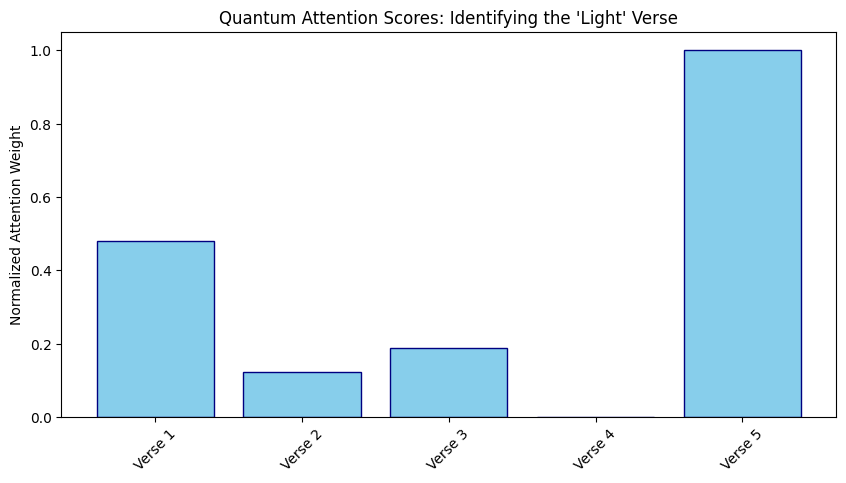

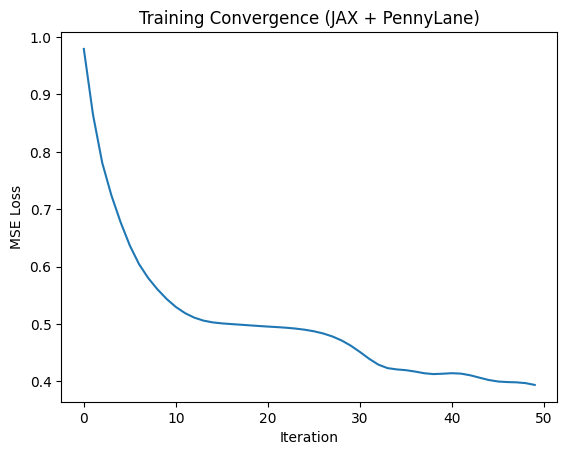

In [7]:
# Get final predictions across the sequence
final_signals = vnode(sequence_data, weights)
# Convert the list of arrays into a single JAX array (shape: n_qubits, num_verses)
final_signals_array = jnp.array(final_signals)
# Sum expectation values across qubits to get a scalar "Attention Score" for each verse
attention_scores = jnp.sum(final_signals_array, axis=0)

# Normalize scores for visualization (0 to 1)
norm_scores = (attention_scores - attention_scores.min()) / (attention_scores.max() - attention_scores.min())

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(range(5), norm_scores, color='skyblue', edgecolor='navy')
plt.xticks(range(5), [f"Verse {i+1}" for i in range(5)], rotation=45)
plt.ylabel("Normalized Attention Weight")
plt.title("Quantum Attention Scores: Identifying the 'Light' Verse")
plt.savefig('attention_scores.png')
plt.show()

# Visualize Loss Curve
plt.plot(losses)
plt.title("Training Convergence (JAX + PennyLane)")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.savefig('loss_curve.png')
plt.show()